# Contour stochastic gradient Langevin dynamics

Sampling in big data problems is fundamentally limited by the multi-modality of the target distributions, with extremely high energy barriers. Multi-modality is often empirically solved via cyclical learning rates or different initializations (parallel chains).

Contour SgLD takes a different approach altogether: the algorithms learns the energy landscape with sampling, and uses this approximation to effectively integrate the diffusion on a flat landscape, before using the importance weight to reweigh the obtained samples.

In this notebook we will compare the performance of SGLD and Contour SGLD on a simple bimodal gaussian target. This example looks simple, but is rather challenging to sample with most methods.

## Gaussian Mixture model

Let us first generate data points that follow a gaussian mixture distributions. The example appears simple, and yet it is hard enough for most algorithms to fail to recover the two modes.

In [1]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp


def gaussian_mixture_model(mu=-5.0, sigma=5.0, gamma=20.0):
    def sample_fn(rng_key, num_samples):
        key1, key2, key3 = jax.random.split(rng_key, 3)
        prob_mixture = jax.random.bernoulli(key1, p=0.5, shape=(num_samples, 1))
        mixture_1 = jax.random.normal(key2, shape=(num_samples, 1)) * sigma + mu
        mixture_2 = jax.random.normal(key3, shape=(num_samples, 1)) * sigma + gamma - mu
        return prob_mixture * mixture_1 + (1 - prob_mixture) * mixture_2

    def logprior_fn(position):
        return 0

    def loglikelihood_fn(position, x):
        mixture_1 = jax.scipy.stats.norm.logpdf(x, loc=position, scale=sigma)
        mixture_2 = jax.scipy.stats.norm.logpdf(x, loc=-position + gamma, scale=sigma)
        return jsp.special.logsumexp(jnp.array([mixture_1, mixture_2])) + jnp.log(0.5)

    return sample_fn, logprior_fn, loglikelihood_fn


sample_fn, logprior_fn, loglikelihood_fn = gaussian_mixture_model()

In [2]:
data_size = 1000

rng_key = jax.random.PRNGKey(888)
rng_key, sample_key = jax.random.split(rng_key)
X_data = sample_fn(sample_key, data_size)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Text(0.5, 1.0, 'Data')

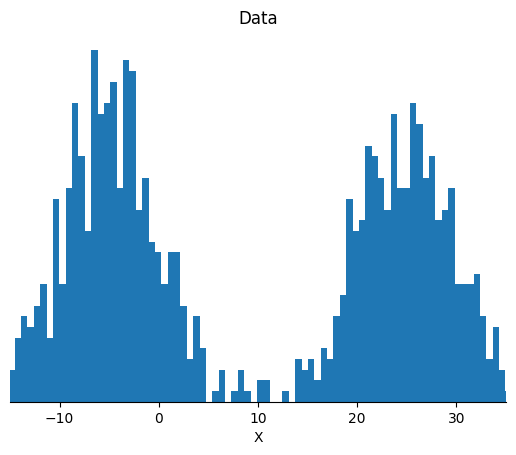

In [3]:
import matplotlib.pylab as plt

ax = plt.subplot(111)
ax.hist(X_data.squeeze(), 100)
ax.set_xlabel("X")
ax.set_xlim(left=-15, right=35)

ax.set_yticks([])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

plt.title("Data")

## Sample with Contour SGLD

In [4]:
from fastprogress import progress_bar

import blackjax
import blackjax.sgmcmc.gradients as gradients

# Specify hyperparameters for SGLD
total_iter = 10_000
thinning_factor = 10

batch_size = 100
lr = 1e-3
temperature = 50.0

init_position = 10.0


# Build the SGDL sampler
grad_fn = gradients.grad_estimator(logprior_fn, loglikelihood_fn, data_size)
sgld = blackjax.sgld(grad_fn)


# Initialize and take one step using the vanilla SGLD algorithm
position = init_position
sgld_sample_list = jnp.array([])

pb = progress_bar(range(total_iter))
for iter_ in pb:
    rng_key, batch_key, sample_key = jax.random.split(rng_key, 3)
    data_batch = jax.random.shuffle(batch_key, X_data)[:batch_size, :]
    position = jax.jit(sgld)(sample_key, position, data_batch, lr, temperature)
    if iter_ % thinning_factor == 0:
        sgld_sample_list = jnp.append(sgld_sample_list, position)
        pb.comment = f"| position: {position: .2f}"

/opt/hostedtoolcache/Python/3.9.16/x64/lib/python3.9/site-packages/jax/_src/random.py:400: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Stochastic gradient Langevin dynamics (SGLD)')

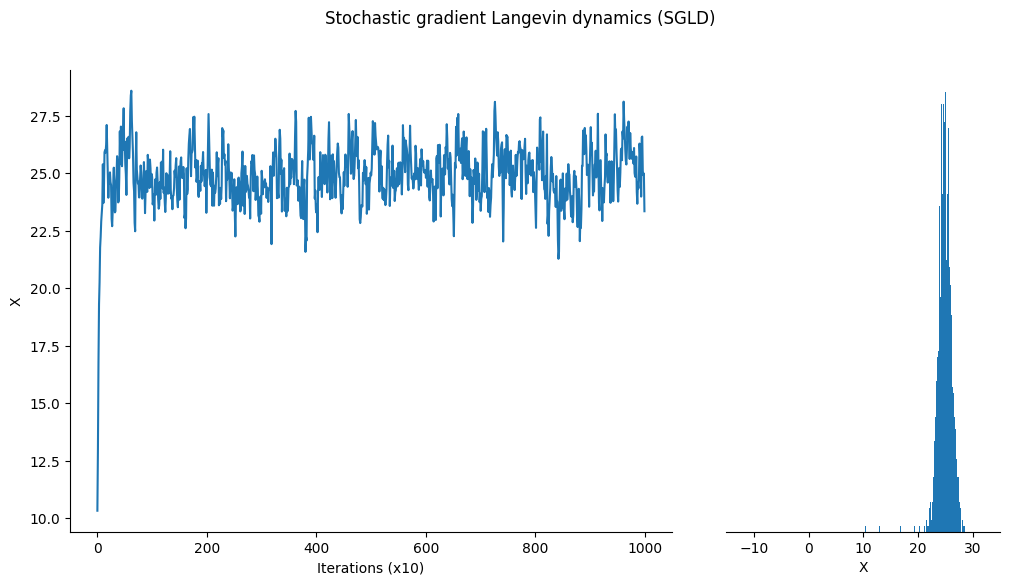

In [5]:
import matplotlib.gridspec as gridspec
import matplotlib.pylab as plt

fig = plt.figure(figsize=(12, 6))

G = gridspec.GridSpec(1, 3)

# Trajectory
ax = plt.subplot(G[0, :2])
ax.plot(sgld_sample_list, label="SGLD")
ax.set_xlabel(f"Iterations (x{thinning_factor})")
ax.set_ylabel("X")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


# Histogram
ax = plt.subplot(G[0, 2])
ax.hist(sgld_sample_list, 100)
ax.set_xlabel("X")
ax.set_xlim(left=-15, right=35)

ax.set_yticks([])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)


plt.suptitle("Stochastic gradient Langevin dynamics (SGLD)")

In [6]:
# specify hyperparameters (zeta and sz are the only two hyperparameters to tune)
zeta = 2
sz = 10
temperature = 50

lr = 1e-3
init_position = 10.0


# The following parameters partition the energy space and no tuning is needed.
num_partitions = 100000
energy_gap = 0.25
domain_radius = 50  # restart sampling when the particle explores too deep over the tails and leads to nan.


logdensity_fn = gradients.logdensity_estimator(logprior_fn, loglikelihood_fn, data_size)
csgld = blackjax.csgld(
    logdensity_fn,
    zeta=zeta,  # can be specified at each step in lower-level interface
    temperature=temperature,  # can be specified at each step
    num_partitions=num_partitions,  # cannot be specified at each step
    energy_gap=energy_gap,  # cannot be specified at each step
    min_energy=0,
)

# 3.1 Simulate via the CSGLD algorithm
state = csgld.init(init_position)

csgld_sample_list, csgld_energy_idx_list = jnp.array([]), jnp.array([])

pb = progress_bar(range(total_iter))
for iter_ in pb:
    rng_key, subkey = jax.random.split(rng_key)
    stepsize_SA = min(1e-2, (iter_ + 100) ** (-0.8)) * sz

    data_batch = jax.random.shuffle(rng_key, X_data)[:batch_size, :]
    state = jax.jit(csgld.step)(subkey, state, data_batch, lr, stepsize_SA)

    if iter_ % thinning_factor == 0:
        csgld_sample_list = jnp.append(csgld_sample_list, state.position)
        csgld_energy_idx_list = jnp.append(csgld_energy_idx_list, state.energy_idx)
        pb.comment = (
            f"| position {state.position: .2f}"
        )

Contour SGLD is a meta-algorithm, based on Stochastic Gradient Langevin Dynamics. It takes inspiration from the Wang-Landau algorithm to learn the density of states of the model at each energy level, and uses this information to "flatten" the target density so the sampler can explore it more easily.

As a result, the samples returned by contour SGLD are not from the target density directly, and we need to resample them using the density of state as importance weights to get samples from the target distribution.

In [7]:
important_idx = jnp.where(state.energy_pdf > jnp.quantile(state.energy_pdf, 0.95))[0]
scaled_energy_pdf = (
    state.energy_pdf[important_idx] ** zeta
    / (state.energy_pdf[important_idx] ** zeta).max()
)

csgld_re_sample_list = jnp.array([])
for _ in range(5):
    rng_key, subkey = jax.random.split(rng_key)
    for my_idx in important_idx:
        if jax.random.bernoulli(rng_key, p=scaled_energy_pdf[my_idx], shape=None) == 1:
            samples_in_my_idx = csgld_sample_list[csgld_energy_idx_list == my_idx]
            csgld_re_sample_list = jnp.concatenate(
                (csgld_re_sample_list, samples_in_my_idx)
            )

Text(0.5, 0.98, 'Contour SGLD')

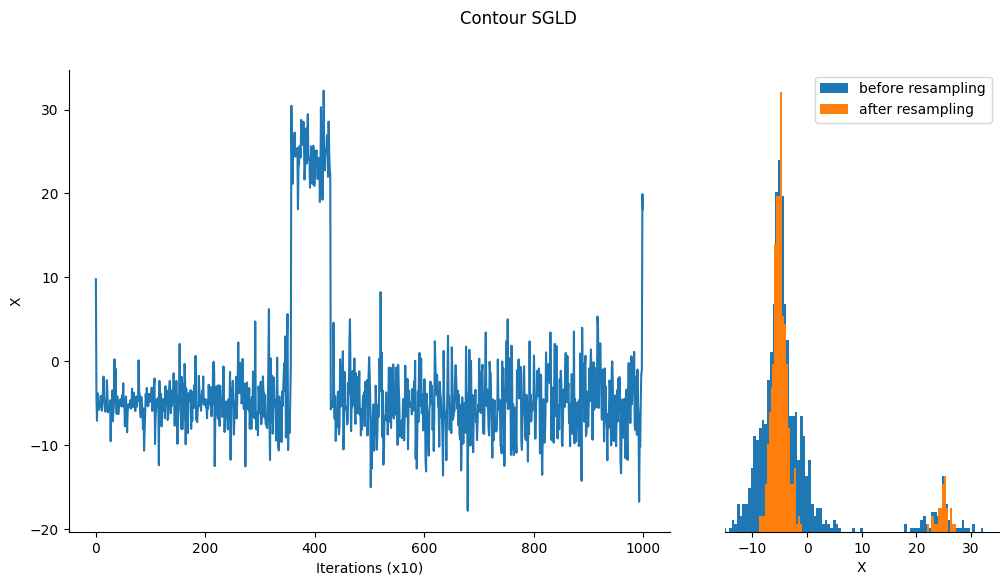

In [8]:
import matplotlib.gridspec as gridspec
import matplotlib.pylab as plt

fig = plt.figure(figsize=(12, 6))

G = gridspec.GridSpec(1, 3)

# Trajectory
ax = plt.subplot(G[0, :2])
ax.plot(csgld_sample_list, label="SGLD")
ax.set_xlabel(f"Iterations (x{thinning_factor})")
ax.set_ylabel("X")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


# Histogram before resampling
ax = plt.subplot(G[0, 2])
ax.hist(csgld_sample_list, 100, label="before resampling")
ax.hist(csgld_re_sample_list, 100, label="after resampling")

ax.set_xlabel("X")
ax.set_xlim(left=-15, right=35)

ax.set_yticks([])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

plt.legend()
plt.suptitle("Contour SGLD")

## How does Contour SGLD work?

The energy density is crucial for us to build a flat density, so let's take a look at the estimation returned by the algorithm. For illustration purposes, we smooth out fluctations and focus on the energy range from 3700 to 100000, which covers the major part of sample space.

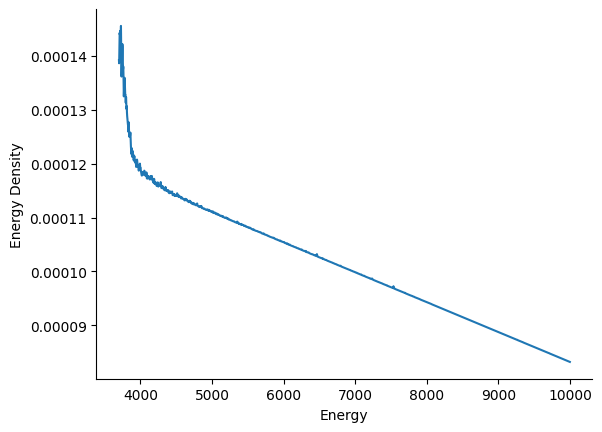

In [9]:
smooth_energy_pdf = jnp.convolve(
    state.energy_pdf, jsp.stats.norm.pdf(jnp.arange(-100, 101), scale=10), mode="same"
)
interested_idx = jax.lax.floor((jnp.arange(3700, 10000)) / energy_gap).astype(
    "int32"
)  # min 3681

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(
    jnp.arange(num_partitions)[interested_idx] * energy_gap,
    smooth_energy_pdf[interested_idx],
)

ax.set_xlabel("Energy")
ax.set_ylabel("Energy Density")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.show()

From the figure above, we see that low-energy regions usually lead to much higher probability mass. Moreover, the slope is negative with a higher scale in low energy regions. In view of Eq.(8) in [the paper]( https://proceedings.neurips.cc/paper/2020/file/b5b8c484824d8a06f4f3d570bc420313-Paper.pdf), we can expect a **negative learning rate** to help the particle escape the local trap. Eventually, a particle is able to bounce out of the deep local traps freely instead of being absorbed into it.

Admittedly, this algorithm is a little sophisticated due to the need to partition the energy space; Learning energy pdf also makes this algorithm delicate and leads to a large variance. However, this allows to escape deep local traps in a principled sampling framework without using any tricks (cyclical learning rates or different initializations). The variance-reduced version is studied in [this work](https://arxiv.org/pdf/2202.09867.pdf).